In [24]:
from typing import Dict, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import gzip 

from datasets import load_dataset
from nltk.tokenize import ToktokTokenizer
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from torch import nn
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from collections import Counter
from IPython.display import clear_output

# Deep Average Network для определения сентимента 

В этой домашке мы будет классифицировать твиты на 3 тональности.  
Вы будете использовать предобученные эмбеддинги слов, так что для начала обязательно нужно посмотреть [туториал по их использованию](https://github.com/BobaZooba/DeepNLP/blob/master/Tutorials/Word%20vectors%20%26%20Data%20Loading.ipynb).

Наши классы:  

Индекс | Sentiment  
-- | --  
0 | negative  
1 | neutral  
2 | positive  

Вам предстоит реализовать такую модель:
![Архитектура модели DAN](https://www.researchgate.net/profile/Shervin-Minaee/publication/340523298/figure/fig1/AS:878252264550411@1586403065555/The-architecture-of-the-Deep-Average-Network-DAN-10.ppm)

Что она из себя представляет:
- Мы подаем в нее индексы слов
- Переводим индексы слов в эмбеддинги
- Усредняем эмбеддинги
- Пропускаем усредненные эмбеддинги через `Multilayer Perceptron`

В этой домашке вам предстоит:
- Перевести тексты в матрицы с индексами токенов
- Реализовать модель
- Обучить ее
- Понять хорошо ли вы это сделали

Это очень важная модель, потому что она очень простая и показывает достаточно высокие метрики. В дальнейшем на работе советую использовать такую модель как бейзлайн. И в качестве эмбеддингов слов взять эмбеддинги от берта/роберты/тд.

## 🤗 Datasets
В этом туториале мы будем использовать подготовленные данные из библиотеки [datasets](https://github.com/huggingface/datasets). Мы вряд ли еще будем пользоваться этой библиотекой, так как нам будет важно самим подготавливать данные. Во-первых, для простоты, во-вторых, здесь есть достаточно неплохие практики. [Здесь](https://huggingface.co/datasets) вы сможете найти достаточно большое количество различных датасетов. Возможно, когда-нибудь они вам пригодятся.

## Загрузите эмбеддинги слов
Реализуйте функцию по загрузке эмбеддингов из файла. Она должна отдавать словарь слов и `np.array`
Формат словаря:
```python
{
    'aabra': 0,
    ...,
    'mom': 6546,
    ...
    'xyz': 100355
}
```
Формат матрицы эмбеддингов:
```python
array([[0.44442278, 0.28644582, 0.04357426, ..., 0.9425766 , 0.02024289,
        0.88456545],
       [0.77599317, 0.35188237, 0.54801261, ..., 0.91134102, 0.88599103,
        0.88068835],
       [0.68071886, 0.29352313, 0.95952505, ..., 0.19127958, 0.97723054,
        0.36294011],
       ...,
       [0.03589378, 0.85429694, 0.33437761, ..., 0.39784873, 0.80368014,
        0.76368042],
       [0.01498725, 0.78155695, 0.80372969, ..., 0.82051826, 0.42314861,
        0.18655465],
       [0.69263802, 0.82090775, 0.27150426, ..., 0.86582747, 0.40896573,
        0.33423976]])
```

Количество строк в матрице эмбеддингов должно совпадать с размером словаря, то есть для каждого токена должен быть свой эмбеддинг. По параметру `num_tokens` должно брать не более указано в этом параметре количество токенов в словарь и матрицу эмбеддингов.

In [2]:
def load_embeddings(file_path, pad_token='PAD', unk_token='UNK', max_words=100_000, verbose=True):
    """
    
    """
    
    vocab = dict()
    embeddings = list()

    with gzip.open(file_path,'rt', encoding="utf8") as file_object:

        vocab_size, embedding_dim = file_object.readline().strip().split()

        vocab_size = int(vocab_size)
        embedding_dim = int(embedding_dim)

        # в файле 1 000 000 слов с векторами, давайте ограничим для простоты этот словарь
        max_words = vocab_size if max_words <= 0 else max_words

        # добавим пад токен и эмбеддинг в нашу матрицу эмбеддингов и словарь
        vocab[pad_token] = 0
        pad_emb = np.zeros(embedding_dim)

        # Я хотел заполнить эмбеддинг NaN'ами, чтобы потом усреднять текст без
        # них, но тогда перестает работать backprop
        # pad_emb[:] = np.nan
        embeddings.append(pad_emb)

        # добавим унк токен и эмбеддинг в нашу матрицу эмбеддингов и словарь
        vocab[unk_token] = 1
        embeddings.append(np.ones(embedding_dim))

        progress_bar = tqdm(total=max_words, disable=not verbose, desc='Reading embeddings file')

        for line in file_object:
            parts = line.strip().split()

            token = ' '.join(parts[:-embedding_dim]).lower()

            if token in vocab:
                continue

            word_vector = np.array(list(map(float, parts[-embedding_dim:])))

            vocab[token] = len(vocab)
            embeddings.append(word_vector)

            progress_bar.update()

            if len(vocab) == max_words:
                break

        progress_bar.close()

    embeddings = np.stack(embeddings)
    
    assert(len(vocab) == embeddings.shape[0])
    
    return vocab, embeddings

In [4]:
# Загружаем эмбеддинги
!wget  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz

# Альтернативный способ (т.к. у меня они загружены на гугл диск)
# from google.colab import drive
# drive.mount('/content/drive')
# %cd ../content/drive/MyDrive/

Mounted at /content/drive
/content/drive/MyDrive


In [3]:
vocab, embeddings = load_embeddings('cc.en.300.vec.gz', max_words=100_000)

Reading embeddings file:   0%|          | 0/100000 [00:00<?, ?it/s]

## Загружаем данные из библиотеки
Мы сразу получим `torch.utils.data.Dataset`, который сможем передать в `torch.utils.data.DataLoader`

In [4]:
dataset_path = "tweet_eval"
dataset_name = "sentiment"

train_dataset = load_dataset(path=dataset_path, name=dataset_name, split="train")
valid_dataset = load_dataset(path=dataset_path, name=dataset_name, split="validation")
test_dataset = load_dataset(path=dataset_path, name=dataset_name, split="test")

Reusing dataset tweet_eval (C:\Users\Audiodrome\.cache\huggingface\datasets\tweet_eval\sentiment\1.1.0\12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)
Reusing dataset tweet_eval (C:\Users\Audiodrome\.cache\huggingface\datasets\tweet_eval\sentiment\1.1.0\12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)
Reusing dataset tweet_eval (C:\Users\Audiodrome\.cache\huggingface\datasets\tweet_eval\sentiment\1.1.0\12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


## `torch.utils.data.DataLoader`

In [15]:
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

## Посмотрим что отдает нам `Loader`
Это батч формата:
```python
batch = {
    "text": [
        "text1",
        "text2",
        ...,
        "textn"
    ],
    "label": tensor([
        1,
        1,
        ...,
        0
    ])
}
```
То есть у нас есть словарь с двумя ключами `text` и `label`, где хранится n примеров. То есть для 5-го примера в батче текст будет храниться в `batch["text"][5]`, а индекс класса будет храниться в `batch["label"][5]`.

In [ ]:
for batch in train_loader:
    break

batch

{'label': tensor([1, 1]),
 'text': ['"Pearl Jam\'s Jeff Aments new project RNDM, here\'s the first single Modern Times, album \'Acts out Oct 26th @user',
  "Who's in Milan in February? You won't want to miss this! #Milano2016"]}

## Collate
Сейчас перед нами стоит проблема: мы получаем тексты в виде строк, а нам нужны тензоры (матрицы) с индексами токенов, к тому же нам нужно западить последовательности токенов, чтобы все сложить в торчовую матрицу. Мы можем сделать это двумя способами:
- Достать из `train/valid/test_dataset` данные и написать свой `Dataset`, где внутри будет токенизировать текст, токены будут переводиться в индексы и затем последовательность будет падиться до нужной длины
- Сделать функцию, которая бы дополнительно обрабатывали наши батчи. Она вставляется в `DataLoader(collate_fn=<ВАША_ФУНКЦИЯ>)`

## Если вы хотите сделать свой `Dataset`
То вы можете достать данные таким образом.

In [ ]:
len(train_dataset["text"]), len(train_dataset["label"])

(45615, 45615)

In [ ]:
train_dataset["text"][:2]

['"QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin"',
 '"Ben Smith / Smith (concussion) remains out of the lineup Thursday, Curtis #NHL #SJ"']

In [ ]:
train_dataset["label"][:2]

[2, 1]

## Если вы хотите сделать `collate_fn`

### Давайте посмотрим что вообще происходит внутри этого метода
Для этого сделаем функцию `empty_collate`, которая принимает на вход батч и отдает его, ничего с ним не делая

In [ ]:
def empty_collate(batch):
    return batch

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=empty_collate)
valid_loader = DataLoader(valid_dataset, batch_size=2, shuffle=False, collate_fn=empty_collate)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=empty_collate)

In [ ]:
for batch in train_loader:
    break

batch

[{'label': 1,
  'text': 'Grateful Dead plays The Beatles   Though it struck me that the latest gens may not know...'},
 {'label': 2,
  'text': '@user I am a big fan, and I would love to 1v1 you on AW on PS4. I am on the 25th Prestige( 10th Master Prestige) And I am pretty skilled."'}]

## Формат батча
```python
batch = [
    {
        "text": "text1",
        "label": 0
    }, 
    {
        "text": "text2",
        "label": 1
    },
    ...,
    {
        "text": "textn",
        "label": 1
    }
]
```
То есть теперь у нас есть список, где каждый элемент — это словарь со значениями `text` и `label`.  

Вы можете сделать функцию или класс с методом `collate`. Этот способ решения домашки предодчтительней, так как использовать `collate` очень хорошая практика.

Что я предлагаю:
- Сделайте класс `Tokenizer`

In [5]:
class Tokenizer:
    
    def __init__(self, base_tokenizer, token2index, pad_token, unk_token, max_length):
        
        self._base_tokenizer = base_tokenizer  # например ToktokTokenizer()
        
        self.token2index = token2index  # словарь из load_embeddings()
        
        self.pad_token = pad_token
        self.pad_index = self.token2index[self.pad_token]
        
        self.unk_token = unk_token
        self.unk_index = self.token2index[self.unk_token]
        
        self.max_length = max_length

    def tokenize(self, text):
        """
        В этом методе нужно разделить строку текста на токены
        """
        return self._base_tokenizer.tokenize(text)
    
    def indexing(self, tokenized_text):
        """
        В этом методе нужно перевести список токенов в список с индексами этих токенов
        """
        idxs = []
        for token in tokenized_text:
            if token not in self.token2index:
                idxs.append(self.unk_index)
            else:
                idxs.append(self.token2index[token])
        return idxs
        
    def padding(self, tokens_indices):
        """
        В этом методе нужно сделать длину tokens_indices равной self.max_length
        Опционально убрать повторяющиеся unk'и
        """
        padded = []

        for idx in tokens_indices:
          if len(padded)==self.max_length:
                break
          elif idx!=1:
              padded.append(idx)
          elif len(padded)==0:
            padded.append(idx)
          else:
              if padded[-1]!=1:
                  padded.append(idx)
        while len(padded)<self.max_length:
          padded.append(self.pad_index)
        return padded
    
    def __call__(self, text):
        """
        В этом методе нужно перевести строку с текстом в вектор с индексами слов нужно размера (self.max_length)
        """
        return torch.tensor(self.padding(self.indexing(self.tokenize(text))))
        
    def collate(self, batch):
        
        tokenized_texts = list()
        labels = list()
        
        for sample in batch:
            labels.append(sample['label'])
            tokenized_texts.append(self(sample['text']))
            
        tokenized_texts = torch.stack(tokenized_texts)
        labels = torch.Tensor(labels)
        
        return tokenized_texts, labels

## Перед реализацией выбранного метода
Советую, чтобы в итоге `Loader` отдавал кортеж с двумя тензорами:
- `torch.Tensor` с индексами токенов, размерность `(batch_size, sequence_length)`
- `torch.Tensor` с индексами таргетов, размерность `(batch_size)`

То есть, чтобы было так:
```python
for x, y in train_loader:
    ...

>> x
>> tensor([[   37,  3889,   470,  ...,     0,     0,     0],
           [ 1509,   581,   144,  ...,     0,     0,     0],
           [ 1804,   893,  2457,  ...,     0,     0,     0],
           ...,
           [  170, 39526,  2102,  ...,     0,     0,     0],
           [ 1217,   172, 28440,  ...,     0,     0,     0],
           [   37,    56,   603,  ...,     0,     0,     0]])

>> y
>> tensor([1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 0, 1, 2, 0, 0, 1,
           0, 2, 1, 1, 0, 1, 2, 0, 2, 1, 2, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 0,
           1, 0, 2, 2, 2, 1, 1, 2, 2, 2, 1, 2, 0, 1, 0, 2, 1, 2, 2, 1, 0, 0, 2, 2,
           2, 1, 2, 0, 2, 2, 0, 2, 0, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 0, 2, 2,
           2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 2, 2, 1, 2, 1,
           2, 1, 1, 2, 2, 1, 1, 2])

>> x.shape
>> torch.Size([128, 64])

>> y.shape
>> torch.Size([128])
```
При условии, что батч сайз равен 128, а максимальная длина последовательности равна 64.

## Помните

## <Место для реализации>

In [8]:
# Определяем max длину текста

lengths = [len(ToktokTokenizer().tokenize(sample)) for sample in tqdm(train_dataset["text"])]
np.percentile(lengths, 94)

  0%|          | 0/45615 [00:00<?, ?it/s]

32.0

In [6]:
wordlim = 32

collate_fn = Tokenizer(ToktokTokenizer(), vocab, 'PAD', 'UNK', wordlim).collate

batch_size = 512

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [30]:
for x,y in train_loader:
    break

In [ ]:
assert(isinstance(x, torch.Tensor))
assert(len(x.size()) == 2)

assert(isinstance(y, torch.Tensor))
assert(len(y.size()) == 1)

# Реализация DAN

На вход модели будут подавать индексы слов

Шаги:
- Переводим индексы слов в эмбеддинги
- Усредняем эмбеддинги
- Пропускаем усредненные эмбеддинги через `Multilayer Perceptron`
    - Нужно реализовать самому
    
Дополнительно:
- Добавьте `nn.Dropout`, `nn.BatchNorm` по вкусу
- Сделайте усреднение с учетом падов
- Используйте эмбеддинги от берта/роберты/тд (когда-нибудь про это будет целый туториал, а пока предлагают вам попробовать сделать это самим)

# Советы

## До обучения
- Выберите метрику(ки) качества и расскажите почему она(они)
    - Обычно есть основная метрика, по которой принимаем решения какие веса брать и дополнительные, которые нам помогут делать выводы, например, о том все ли хорошо с нашими данными, хорошо ли модель справляется с дисбалансом классов и тд
- Эту домашку можно сделать и на `CPU`, но на `GPU` будет сильно быстрее
    - Во всех остальных домашках мы будем учить модели на `GPU`
    - Рано или поздно вам придется посмотреть этот [туториал](https://www.youtube.com/watch?v=pgk1zGv5lU4)
    - Вы можете обучаться на `colab`, это бесплатно

## До эпохи
- Сделайте списки/словари/другое, чтобы сохранять нужные данные для расчета метрик(и) по всей эпохе для трейна и валидации

## Во время эпохи
- Используйте [`tqdm`](https://github.com/tqdm/tqdm) как прогресс бар, чтобы понимать как проходит ваше обучение
- Логируйте лосс
- Логируйте метрику(ки) по батчу
- Сохраняйте то, что вам нужно, чтобы посчитать метрик(и) на всю эпоху для трейна и валидации

## После эпохи
- Посчитайте метрик(и) на всю эпоху для трейна и валидации

## После обучения
- Провалидируйтесь на тестовом наборе и посмотрите метрики
- Постройте [`classification_report`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)
- Постройте графики:
    - [Confusion Matrix](https://scikit-learn.org/stable/modules/model_evaluation.html#confusion-matrix)
    - [Опционально] Распределение вероятностей мажоритарного класса (то есть для какого-то примера мы выбираем такой класс и вероятность этого выбора такая-то) на трейне/тесте/валидации
        - Если класс был выбран верно и если была ошибка
- Подумайте что еще вам будет полезно для того, чтобы ответить на такие вопросы: 
    - Что в моделе можно улучшить?
    - Все ли хорошо с моими данными?
    - Все ли хорошо с валидацией?
    - Не переобучился ли я?
    - Достаточно ли я посмотрел на данные?
    - Нужно ли мне улучшить предобработку данных?
    - Нужно ли поменять токенизацию или эмбеддинги?
    - Нет ли у меня багов в реализации?
    - Какие типичные ошибки у моей модели?
    - Как я могу их исправить?

# Я выбрал метрику F1 weighted
Почему я выбрал эту метрику:  
Как можно видеть в результате кода ниже, количество данных сильно разнится для разных классов. Т.к. наша модель может научиться предсказывать одни классы лучше других, я посчитал необходимым использовать взвешенную метрику, ведь в таком случае не будет перевеса в сторону классов с большим количеством данных.

In [ ]:
# Смотрим на дисбаланс классов в training set'е

train_classes = [data['label'] for data in train_dataset]
Counter(train_classes)

Counter({2: 17849, 1: 20673, 0: 7093})

In [10]:
# Смотрим на дисбаланс классов в validation set'е

val_classes = [data['label'] for data in valid_dataset]
Counter(val_classes)

Counter({1: 869, 2: 819, 0: 312})

In [11]:
# Смотрим на дисбаланс классов в test set'е

test_classes = [data['label'] for data in test_dataset]
Counter(test_classes)

Counter({1: 5937, 2: 2375, 0: 3972})

In [12]:
class DeepAverageNetwork(nn.Module):
    
    def __init__(self, actv, embs, hidden_unit_nums, output_feature_num, drop):
        
        super(DeepAverageNetwork, self).__init__()
        
        self.emb = torch.nn.Embedding.from_pretrained(torch.Tensor(embs))
        
        self.mlp = nn.Sequential() # сюда добавим все mlp-слои
        in_num = self.emb.embedding_dim # инпуты первого слоя
        
        for i in range(len(hidden_unit_nums)): # создаем одинаковые группы слоев
          out_num = hidden_unit_nums[i] # назначаем аутпуты из соответствующего листа
          layer = nn.Linear(in_num, out_num) # линейный слой
          in_num = out_num # инпуты следующего слоя
          self.mlp.add_module('Linear_%d'%i, layer) # добавляем в последовательность

          batchnorm = nn.BatchNorm1d(num_features=out_num) # нормализация батча
          self.mlp.add_module('Batchnorm_%d'%i, batchnorm) # добавляем в последовательность

          actv_layer = eval('nn.%s'%actv) # функция активации
          self.mlp.add_module('Activation_%d'%i, actv_layer) # добавляем в последовательность

          dropout = nn.Dropout(p=drop[i]) # дропаут
          self.mlp.add_module('Dropout_%d'%i, dropout) # добавляем в последовательность

        out_layer = nn.Linear(in_num, output_feature_num) # Create final layer
        self.mlp.add_module('Output_Linear', out_layer) # добавляем в последовательность

    def forward(self, x):
        x = self.emb(x)
        x_avg = x.nanmean(1)
        logits = self.mlp(x_avg)
        return logits

In [13]:
# Функция для инициализации весов
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        m.bias.data.fill_(0)

In [20]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

hidden_units = [375, 400, 500, 600] # нейронов в скрытых слоях
dropouts = [0.2, 0.25, 0.4, 0.5] # дропаут на этих слоях

model = DeepAverageNetwork('ReLU()', embeddings, hidden_units, 3, dropouts)
model.apply(init_weights)
model.to(device)

DeepAverageNetwork(
  (emb): Embedding(100000, 300)
  (mlp): Sequential(
    (Linear_0): Linear(in_features=300, out_features=375, bias=True)
    (Batchnorm_0): BatchNorm1d(375, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (Activation_0): ReLU()
    (Dropout_0): Dropout(p=0.2, inplace=False)
    (Linear_1): Linear(in_features=375, out_features=400, bias=True)
    (Batchnorm_1): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (Activation_1): ReLU()
    (Dropout_1): Dropout(p=0.25, inplace=False)
    (Linear_2): Linear(in_features=400, out_features=500, bias=True)
    (Batchnorm_2): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (Activation_2): ReLU()
    (Dropout_2): Dropout(p=0.4, inplace=False)
    (Linear_3): Linear(in_features=500, out_features=600, bias=True)
    (Batchnorm_3): BatchNorm1d(600, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (Activation_3): ReLU()
 

## Задайте функцию потерь и оптимизатор

In [21]:
tokenizer = Tokenizer(ToktokTokenizer(), vocab, 'PAD', 'UNK', wordlim)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
criterion = nn.CrossEntropyLoss(reduction='none')
# Задаем шедулер, который будет снижать LR, если параметр перестает снижаться
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       mode='min',
                                                       factor=0.7,
                                                       patience=1,
                                                       verbose=True)

## Сделайте цикл обучения

In [16]:
# Вспомогательные функции

# Функция для выведения графиков
def plot_losses(train_losses, test_losses, train_metrics, test_metrics):
    
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(train_metrics) + 1), train_metrics, label='train')
    axs[1].plot(range(1, len(test_metrics) + 1), test_metrics, label='test')
    axs[1].set_ylabel('F1 weighted')

    for ax in axs:
        ax.grid()
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()

    
# Одна эпоха обучения
def train_one_epoch(model, train_loader, tokenizer, criterion, optimizer, epoch, num_epochs, device="cuda:0"):
    
    model.train()
    running_loss, running_metric = 0.0, 0.0
    
    for texts, labels in tqdm(train_loader, desc=f'Training {epoch+1}/{num_epochs}'):
        optimizer.zero_grad() # обнуляем градиенты

        texts = texts.to(device)
        labels = labels.to(device)
        
        logits = model(texts) # форвард пасс
        loss = criterion(logits, labels.long()) # считаем лосс
        loss.mean().backward() # бэквард пасс
        optimizer.step() # обновляем веса

        running_loss += loss.sum() # складываем потери (среднее считается ниже)
        running_metric += f1_score(labels.cpu(), logits.argmax(dim=-1).cpu(), average='weighted') # складываем метрики
    return running_loss, running_metric

# Получение предсказаний модели (форвард пасс аналогичен предыдущей функции, но в режиме model.eval())
def predict(model, val_loader, criterion, device="cuda:0"):
    
    model.eval()
    losses, predicted_classes, true_classes = [], [], []
    
    for texts, labels in tqdm(val_loader, desc=f'Testing'):
        texts = texts.to(device)
        labels = labels.to(device)
        
        with torch.no_grad():
            logits = model(texts)
            loss = criterion(logits, labels.long())
        
        losses += [loss]
        predicted_classes += [logits.argmax(dim=-1)] 
        true_classes += [labels]
    # На выход отдаем вектора лоссов, предсказанных значений и истинных значений
    return torch.cat(losses), torch.cat(predicted_classes).cpu(), torch.cat(true_classes).cpu()


# Цикл обучения
def train(model, train_loader, val_loader, tokenizer, criterion, optimizer, device="cuda:0", n_epochs=10, scheduler=None):
    
    train_losses, test_losses = [], [] # Сюда будем складывать лоссы
    train_metrics, test_metrics = [], [] # Сюда будем складывать значения метрики
    
    for epoch in range(n_epochs):
        # Обучаем
        epoch_loss, epoch_metric = train_one_epoch(model,
                                                   train_loader,
                                                   tokenizer,
                                                   criterion,
                                                   optimizer,
                                                   epoch,
                                                   n_epochs,
                                                   device)
        train_losses += [epoch_loss / len(train_loader.dataset)] # среднее значение лосса по train set'у
        # среднее значение метрики по train set'у
        # (не очень точно, т.к. размер последнего батча может отличаться, но для графика сгодится)
        train_metrics += [epoch_metric * batch_size / len(train_loader.dataset)] 

        # Тестируем после эпохи
        all_losses, predicted_labels, true_labels = predict(model,
                                                            val_loader,
                                                            criterion,
                                                            device)
        test_losses += [torch.mean(all_losses).item()] # среднее значение лосса по validation set'у
        # среднее значение метрики по validation set'у
        test_metrics += [f1_score(true_labels, predicted_labels, average='weighted')]
        
        plot_losses(train_losses, test_losses, train_metrics, test_metrics) # строим график после каждой эпохи

        if scheduler:
            # Шедулер ориентируем на лосс по валидационному сету (не на F1, т.к. градиенты мы считаем все же по лоссу)
            scheduler.step(test_losses[-1])

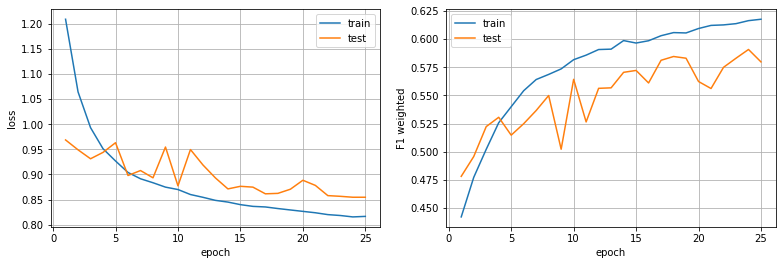

In [22]:
NUM_EPOCHS = 25  # Задайте количество эпох

train(model, train_loader, valid_loader, tokenizer, criterion, optimizer, device, NUM_EPOCHS, scheduler)

In [23]:
all_losses, predicted_labels, true_labels = predict(model, test_loader, criterion, device)
assert len(predicted_labels) == len(test_dataset)
metric = f1_score(true_labels, predicted_labels, average='weighted')
metric

Testing:   0%|          | 0/24 [00:00<?, ?it/s]

0.585092308449526

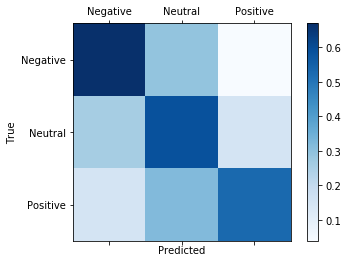

In [36]:
# Строим confusion matrix
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion_matrix(predicted_labels, true_labels, normalize='true'), cmap=plt.cm.Blues)
fig.colorbar(cax)

labels = ['', 'Negative', 'Neutral', 'Positive']
ax.set_xticklabels(labels)
ax.set_xlabel('Predicted')
ax.set_yticklabels(labels)
ax.set_ylabel('True')

plt.show()
# disp = ConfusionMatrixDisplay.from_estimator(
#         classifier,
#         X_test,
#         y_test,
#         display_labels=class_names,
#         cmap=plt.cm.Blues,
#         normalize=normalize,
#     )

# Выводы
Напишите небольшой отчет о проделанной работе. Что удалось, в чем не уверены, что делать дальше.

Пробовал разные гиперпараметры для данной модели, но выше 0.60 F1 на тестовом сете не поднимается.  
Вероятно, качество улучшилось бы, если бы паддинги не учитывались при подсчете среднего. Я пытался это сделать, заменив нули в эмбеддинге PAD-токенов на NaN'ы (вторая ячейка кода, строка 25), но тогда перестает корректно работать backprop (функция mean() распространяет NaN в градиентах, а с функцией nanmean() модель почему-то перестает обучается - лосс не падает).  
Весьма вероятно, также, что выбор другого словаря для эмбеддингов хорошо отразился бы на качестве модели, но времени попробовать разные уже не было.  